In [256]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

## parameters

In [444]:
class p:
    # data parameters
    N = 2000 # N is batch size
    layer_sizes = [1, 5, 2] # input, hidden1, hidden..., output
    means = [[0], [20], [40]] # means of gaussian data
    sds = [[1], [1], [1]] # sds of data
#     means = [[0], [20]]
#     sds = [[1], [1]]
    labs = [0, 1, 0] # labels of these gaussians
#     labs = [0, 1]
    
    # model parameters
    num_layers = len(layer_sizes) - 1
    
    # fitting paramters
    lr = 1e-6
    num_iters = int(1e3)
    step_size_optimizer = 1000
    gamma_optimizer = 0.9

# generate data

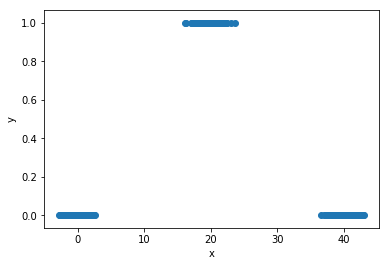

In [445]:
# generate mixture model
# means and sds should be lists of lists (sds just scale variances)
def generate_gaussian_data(N, means=[[0], [1]], sds=[1, 1], labs=[0, 1]):
    num_means = len(means)
    P = len(means[0])
    X = np.zeros((N, P), dtype=np.float32)
    y_plot = np.zeros((N, 1), dtype=np.float32)
    y_one_hot = np.zeros((N, 2), dtype=np.float32)
    for i in range(N):
        z = np.random.randint(num_means) # select gaussian
        X[i] = np.random.multivariate_normal(means[z], np.eye(P) * sds[z])
        y_plot[i] = labs[z]
        y_one_hot[i, labs[z]] = 1
    return X, y_one_hot, y_plot


# data to torch
class dset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, idx):
        return X[idx], y[idx]
    def __len__(self):
        return y.size

X, y, y_plot = generate_gaussian_data(p.N, means=p.means, sds=p.sds, labs=p.labs)
dset = dset(X, y)
plt.scatter(X, y_plot)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## run + fit

In [446]:
# data to torch
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)


# make model
model = torch.nn.Sequential(
    torch.nn.Linear(p.layer_sizes[0], p.layer_sizes[1]),
    torch.nn.ReLU(),
#     torch.nn.Linear(p.layer_sizes[1], p.layer_sizes[2]),
#     torch.nn.ReLU(),
    torch.nn.Linear(p.layer_sizes[-2], p.layer_sizes[-1]),
    torch.nn.Softmax()
)

# freeze
# model.2.weight = 2
# instead of model.parameters(), only pass what you wanna optimize

# set up optimization
optimizer = torch.optim.SGD(model.parameters(), lr=p.lr) # only optimize ridge (otherwise use model.parameters())
scheduler = StepLR(optimizer, step_size=p.step_size_optimizer, gamma=p.gamma_optimizer)
loss_fn = torch.nn.MSELoss(size_average=False)


# to record
weights = {}
losses = np.zeros(p.num_iters)
norms = np.zeros((p.num_iters, p.num_layers))
accs = np.zeros(p.num_iters)


# fit
for it in tqdm(range(p.num_iters)):
    y_pred = model(Variable(X_torch, requires_grad=True)) # predict
    loss = loss_fn(y_pred, Variable(y_torch)) # calculate loss
    optimizer.zero_grad() # zero the gradients
    loss.backward() # backward pass
    optimizer.step() # update weights
    scheduler.step() # step for incrementing optimizer
    
    # output
    weight_dict = {x[0]:x[1].data.numpy() for x in model.named_parameters()}
    if it % 100 == 0:
        weights[it] = weight_dict
    losses[it] = loss.data[0] 
    accs[it] = np.mean(np.argmax(y_pred.data.numpy(), axis=1) == y_plot) * 100
    norms[it, 0] = np.linalg.norm(weight_dict['0.weight'])**2 + np.sum(weight_dict['0.bias']**2)
    norms[it, 1] = np.linalg.norm(weight_dict['2.weight'])**2 + np.sum(weight_dict['2.bias']**2)

  0%|          | 0/1000 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 1000/1000 [00:10<00:00, 98.54it/s]


# analyze results

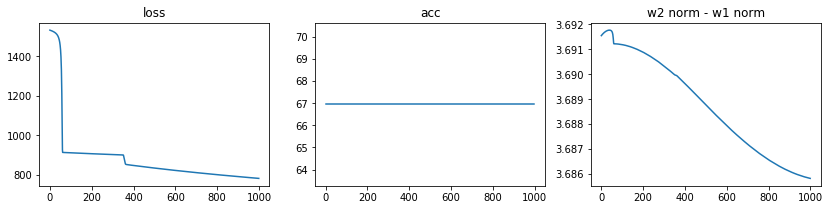

781.9403686523438


In [447]:
# plot loss and norms
plt.figure(figsize=(14, 3))
plt.subplot(131)
plt.plot(losses)
plt.title('loss')


plt.subplot(132)
plt.plot(accs)
plt.title('acc')

plt.subplot(133)
plt.plot(norms[:, 0] - norms[:, 1])
plt.title('w2 norm - w1 norm')
plt.show()

print(losses[-1])

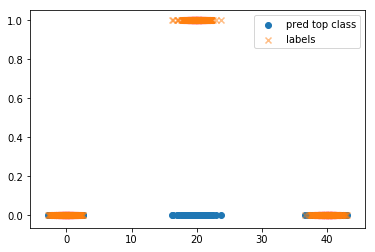

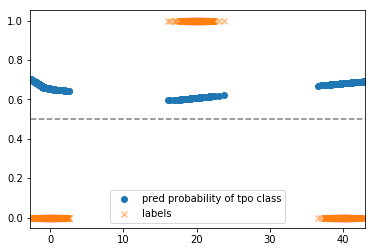

In [448]:
# plot predictions
preds = y_pred.data.numpy()
plt.scatter(X, np.argmax(preds, axis=1), label='pred top class')
plt.scatter(X, np.argmax(y, axis=-1), label='labels', alpha=0.5, marker='x')
plt.legend()
plt.show()

plt.scatter(X, np.max(preds, axis=1), label='pred probability of tpo class')
plt.scatter(X, np.argmax(y, axis=-1), label='labels', alpha=0.5, marker='x')
plt.plot([-1000, 1000], [.5, .5], '--', color='gray')
plt.xlim([np.min(X), np.max(X)])
plt.legend()
plt.show()